In [1]:
import sys
sys.path.insert(1, '../src/')

import json, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gemini_wrapper as gemini
import rag
import time

In [2]:
corpus = json.loads(open('../BData/parsed_data/corpus.json').read())

In [3]:
def extract_metrics(corpus, doc):
    data = [k for k in corpus if k['doc'] == doc]
    pages = len(data)
    if pages <= 0:
        return doc, 0, 0, 0
    
    lens = [len(k['txt']) for k in data]
    max_chars = max(lens)
    min_chars = min(lens)

    return doc, pages, max_chars, min_chars

def extract_json(txt):
    m = re.match('```json(.+)```', txt, re.DOTALL)
    if m is None:
        return txt
    
    return m.group(1).strip()   

def generate_question(context):
    qgen_template = open('../metadata/question_gen_prompt_sample.md').read()
    output_template = open('../metadata/question_gen_prompt_sample_out.json').read()
    prompt = qgen_template.format(output=output_template, context=context)
    r = gemini.ask(prompt)
    js = json.loads(extract_json(r))
    js['context'] = context

    return js    

def generate_questions():
    gemini.configure()

    question_db = []
    nquestions = 100
    for k in range(nquestions):
        w = len(corpus) // nquestions
        i = k * w + 7
        doc, page = corpus[i]['doc'], corpus[i]['page']
        print(f'Generating question for doc {doc}, page {page}')
        context = corpus[i]['txt']
        js = generate_question(context)
        js['doc'] = doc
        js['page'] = page

        question_db.append(js)

        time.sleep(5)

    print('finished')
    open('../metadata/questions.json', 'w+').write(json.dumps(question_db))

In [4]:
total_docs = corpus[-1]['doc']+1
mtx = []
for i in range(total_docs):
    mtx.append(extract_metrics(corpus, i))

In [5]:
meta_df = pd.DataFrame(mtx, columns=['doc', 'pages', 'max_chars', 'min_chars'])
meta_df

,doc,pages,max_chars,min_chars
0,0,37,3019,332
1,1,1,3625,3625
2,2,8,5962,337
3,3,71,3154,346
4,4,1,1101,1101
...,...,...,...,...
604,604,4,3670,2430
605,605,135,7909,202
606,606,6,4231,2305
607,607,5,3144,1086


Text(0.5, 1.0, 'Density distribution of pages per text document.')

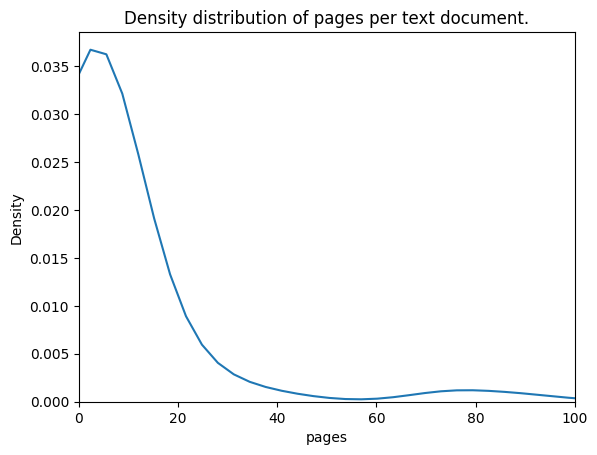

In [6]:
_, ax = plt.subplots()
ax.set_xlim([0, 100])
sns.kdeplot(meta_df.pages, ax=ax)
ax.set_title('Density distribution of pages per text document.')

In [17]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def to_perc(v):
    return f'{int(v * 100)}%'

questions_db = json.loads(open('../metadata/questions.json').read())

In [21]:
mtx = []
for i in range(len(questions_db)):
    print(f'processing question {i}')
    q = questions_db[i]
    r = rag.Rag()
    ans = r.execute(q['question'])
    met = similar(q['answer'], ans['answer'])
    mtx.append([q, ans, met])
    time.sleep(5)

print('finished')

processing question 0
processing question 1
processing question 2
processing question 3
processing question 4
processing question 5
processing question 6
processing question 7
processing question 8
processing question 9
processing question 10
processing question 11
processing question 12
processing question 13
processing question 14
processing question 15
processing question 16
processing question 17
processing question 18
processing question 19
processing question 20
processing question 21
processing question 22
processing question 23
processing question 24
processing question 25
processing question 26
processing question 27
processing question 28
processing question 29
processing question 30
processing question 31
processing question 32
processing question 33
processing question 34
processing question 35
processing question 36
processing question 37
processing question 38
processing question 39
processing question 40
processing question 41
processing question 42
processing question 4

In [22]:
open('../metadata/metrics.json', 'w+').write(json.dumps(mtx))

250937

In [19]:
for q, ans, met in mtx:
    print('Question:', q['question'])
    print('Provided Answer:', q['answer'])
    print('RAG Answer:', ans['answer'])
    print('Answer Similarity:', to_perc(met))

    print()
    print('#'*80)
    print()

Question: What equipment is included in Level 2 Vacuum Plantroom 13.018 (64.2.083)?
Provided Answer: A packaged medical vacuum plant, a local final circuit distribution board, and a Windcatcher controller for the Second Floor & Atrium.
RAG Answer: Packaged medical vacuum plant, local final circuit distribution board, and windcatcher controller for Second Floor & Atrium.
Answer Similarity: 94%

################################################################################

Question: What temperature difference triggers the Plate Heat Exchanger (PHE) to operate in heating mode?
Provided Answer: The PHE operates in heating mode if the return air temperature is greater than the outside air/inlet air temperature by 1°C.
RAG Answer: If the return air temperature is greater than the outside air/inlet air temperature by 1˚C, the PHE will be available to operate in heating mode.
Answer Similarity: 66%

################################################################################

Question:

In [39]:
def process_result(q, ans, met):
    loc_match = ans['doc'] == q['doc']
    return q['question'], q['answer'], ans['answer'], ans['valid'], loc_match, met

In [40]:
arr = [process_result(q, ans, met) for q, ans, met in mtx]
df = pd.DataFrame(arr, columns=['question', 'answer', 'rag answer', 'valid', 'loc_match', 'similarity'])

In [41]:
df

,question,answer,rag answer,valid,loc_match,similarity
0,What equipment is included in Level 2 Vacuum P...,"A packaged medical vacuum plant, a local final...","Packaged medical vacuum plant, local final cir...",True,True,0.945736
1,What temperature difference triggers the Plate...,The PHE operates in heating mode if the return...,If the return air temperature is greater than ...,True,False,0.661710
2,Who is the Contract Administrator (CA) accordi...,The Project Manager.,The Project Manager will carry out the duties ...,True,True,0.396040
3,What company is specified to supply the bedhea...,Cableflow International Limited,Cableflow International Limited,True,True,1.000000
4,What specific aspects of existing installation...,"Step 7 surveys for adequacy, safety, condition...",Step 7 surveys existing installations for adeq...,True,True,0.832090
...,...,...,...,...,...,...
95,What is the recommended maximum lifespan of th...,"10 years from the date of manufacture, althoug...","Due to seals aging, to ensure safe operation, ...",True,False,0.503401
96,What is the default value for the Access Point...,Disabled,Disabled,True,False,1.000000
97,What pressure stages are specified for the MUL...,"PN16/PN25 (general), PN25 for Kamstrup sensor ...",PN16/PN25,True,False,0.189474
98,Which European Union directives are mentioned ...,The text mentions 2004/108/EC (Electromagnetic...,2004/108/EC Electromagnetic Compatibility Dire...,True,False,0.658065


In [26]:
df.valid.sum()

93

In [42]:
df.loc_match.sum()

24

In [30]:
sum((df.valid) & (df.similarity > .5))

58

In [43]:
df[df.similarity > .95]

,question,answer,rag answer,valid,loc_match,similarity
3,What company is specified to supply the bedhea...,Cableflow International Limited,Cableflow International Limited,True,True,1.000000
8,What is the required written notice period for...,10 working days.,10 working days,True,True,0.967742
10,"According to the provided text, what regulatio...",Regulation 444 of the IET Wiring Regulations.,Regulation 444 of the IET Wiring Regulations.,True,True,1.000000
12,What is the purpose of the BIM Kick-off meetin...,To define the scope of BIM for the project wit...,To define the scope of BIM for the project wit...,True,False,1.000000
13,Which standards are referenced for earthing an...,"HTM's, HBN's, BS 7671, and BS 7430.","HTMs, HBNs, BS 7671, and BS 7430.",True,False,0.970588
14,What are the operating hours for staff assista...,"Monday - Friday: 05:00 - 01:10, Saturday: 05:3...","Monday - Friday: 05:00 - 01:10, Saturday: 05:3...",True,True,1.000000
21,What user interface options are available for ...,Three user interface options are available: to...,Three user interface options are available: to...,True,False,1.000000
24,What Modbus function code is used to read non-...,100-4,100-4,True,False,1.000000
27,What is the issue number and date of issue for...,"Issue Number: 7.0, Date of Issue: 08/12/2016","Issue Number: 7.0, Date of Issue: 08/12/2016",True,False,1.000000
28,What are the available choices for the 'Occupa...,"Motion, Schedule, Mot. Occ., Mot. Unoc.","Motion, Schedule, Mot. Occ., Mot. Unoc.",True,False,1.000000


In [32]:
q, a, m = mtx[0]
q

{'question': 'What equipment is included in Level 2 Vacuum Plantroom 13.018 (64.2.083)?',
 'answer': 'A packaged medical vacuum plant, a local final circuit distribution board, and a Windcatcher controller for the Second Floor & Atrium.',
 'context': 'RUH - Bath Systems Description      \nDyson Cancer Centre Section 2 - Mechanical  \n  \nIntegral Ltd - Bristol Revision: Revision Date:  Page 8 of 37 \n \n -  Secondary LTHW Pump Set \n -  Tertiary LTHW Pump Set \n -  Tertiary LTHW Pressurisation Unit and Expansion Vessel \n -  BMS Control Panel – MCC2 \n -  CHW pressurisation and expansion vessel \n -  Chiller Sequencing Panel \n -  Local final circuit distribution board \n -  Automatic Transfer Switches (ATS) \n -  PV Inverters \n - Air Conditioning central controller & leak detection panel \n \n \n     2.2.6  Level 2 – Vacuum Plantroom – 13.018 (64.2.083) \n \n The plantroom located on level 2 contains the packaged medical \n vacuum plant which comprises of 2 No. vessels and triplex pu